# Clasificación de imágenes

En este notebook vamos a desarrollar un módelo para clasificar gatos o perros a partir de imágenes. Para esto utilizaremos un clasificador de imágenes usando un modelo `tf.keras.Sequential` y para la carga datos usaremos `tf.keras.preprocessing.image.ImageDataGenerator`.

Seguiremos el siguiente orden de tareas:

1. Examinar y entender los datos
2. Construir un pipeline de entrada
3. Construir un modelo.
4. Entrenar el modelo
5. Testear el modelo
6. Mejorar el modelo aplicando técnicas y volver a entranar.

## Repaso sobre elementos a utilizar para este ejemplo 

Keras es muy bueno para la creación rápida de prototipos. En poco tiempo se puede construir un modelo que logre resultados muy buenos.

### 1 - Para cargar los datos:
Como se mencionó vamos a utilizar `tf.keras.preprocessing.image.ImageDataGenerator` que se debe inicializar para cada tipo de datos que tengamos (train, dev, etc).
Un ej de como hacerlo es: `gen = ImageDataGenerator(rescale=1./255)`

Como en nuestro caso vamos a leer los archivos desde varias carpetas, podemos utilizar:
```
gen.flow_from_directory(batch_size=batch_size,
                    directory=train_dir,
                    shuffle=True,
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    class_mode='binary')
```

### 2 - Definir un modelo:

Como utilizaremos modelos secuenciales, en cada etapa se le aplica una operacion a la vez a la CNN, podemos usar:
```
model = Sequential([
    ...
    ...
    ...
])
```
Dentro de los parentesis rectos se pueden concatenar tantas operaciones como se quiera, siendo algunos ejemplos:
 * Conv2D(filters=16, kernel_size=(7, 7), strides=(1, 1), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3))
 * BatchNormalization(axis=3)
 * MaxPooling2D((2,2))
 * Flatten()
 * Dense(units=512, activation='relu')
```
model = Sequential([
    Conv2D(filters=16, kernel_size=(7, 7), strides=(1, 1), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    BatchNormalization(axis=3),
    ...
    ...
])
```
### 3 - Compilar el modelo
```
model.compile(optimizer= , nombre_optimizador
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), función de pérdida
              metrics=[]) arreglo con todas las metricas a sacar
```

### 4 - Entrenar el modelo
Para esto la clase ImageDataGenerator tiene el método fit en donde algunos parámetros a configurar son:
```
model.fit(
    train_data_gen,  conjunto de entrenamiento
    steps_per_epoch= ,  # de pasos en cada epochs
    epochs= ,  # de epochs
    validation_data= , conjunto de validacion
    validation_steps= 
)
```



## Import packages

* El paquete `os` se usa para leer archivos y estructura de directorios
* `NumPy` se usa para realizar las operaciones de matriz requeridas
* `matplotlib.pyplot` para gráficar y mostrar imágenes en los datos de entrenamiento y validación.

Importar Tensorflow y las clases de Keras necesarias para construir nuestro modelo.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## Cargar datos

El conjunto de datos tiene la siguiente estructura:
<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

Asignar las variables con la ruta de archivo adecuada para el conjunto de capacitación y validación.

In [4]:
train_dir = os.path.join('datasets', 'train_red')
validation_dir = os.path.join('datasets', 'validation')

In [5]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

## Estudiando el dataset

In [6]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [7]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 201
total training dog images: 201
total validation cat images: 500
total validation dog images: 500
--
Total training images: 402
Total validation images: 1000


Configurar las variables que se utilizaron para el mini-batch, las épocas y las dimensiones de las imagenes.

In [68]:
batch_size = 32
epochs = 30
IMG_HEIGHT = 128
IMG_WIDTH = 128

Formatear las imágenes en tensores de punto flotante preprocesados ​​adecuadamente antes de alimentar a la red:

1. Leer imágenes del disco.
2. Docodificar el contenido de estas imágenes y convertirlo al formato de cuadrícula adecuado según su contenido RGB.
3. Convertirlos en tensores de punto flotante.
4. Cambiar la escala de los tensores de valores entre 0 y 255 a valores entre 0 y 1, ya que las redes neuronales prefieren tratar con valores de entrada pequeños.

Todas estas tareas se pueden realizar con la clase `ImageDataGenerator` proporcionada por `tf.keras`. Puede leer imágenes del disco y preprocesarlas en tensores adecuados. También establecerá generadores que conviertan estas imágenes en batch de tensores, lo que es útil para entrenar la red.

In [69]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

Después de definir los generadores para las imágenes de entrenamiento y validación, el método `flow_from_directory` carga las imágenes desde el disco, aplica el cambio de escala y cambia el tamaño de las imágenes a las dimensiones requeridas.

In [70]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           color_mode='rgb')

Found 402 images belonging to 2 classes.


In [71]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### Visualizar ejemplos de entrenamiento

Visualizar las imágenes de entrenamiento extrayendo un lote de imágenes del generador de entrenamiento, que son 32 imágenes en este ejemplo, luego graficar cinco de ellas con `matplotlib`.

In [72]:
sample_training_images, _ = next(train_data_gen)

La función `next` devuelve un batch del conjunto de datos. El valor de retorno de la función `next` está en forma de `(x_train, y_train)` donde x_train son las características de entrenamiento y y_train, sus etiquetas.

In [73]:
# This function will plot images in the form of a grid with 1 row and 8 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 8, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

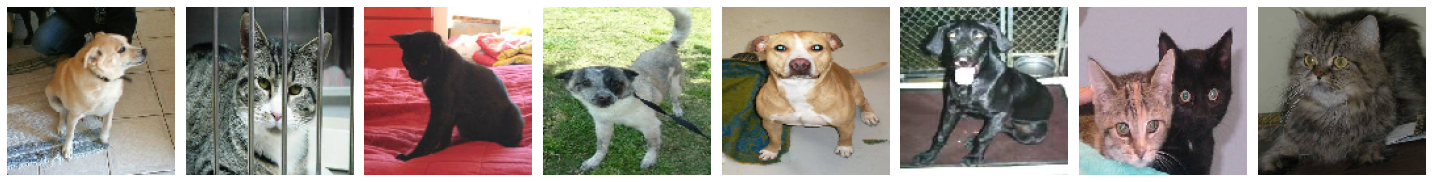

In [74]:
plotImages(sample_training_images[:8])

In [75]:
# Ver algunos datos mas del dataset
print("Labels conjunto entrenamiento:", train_data_gen.classes)
print("Indices de las clases:", train_data_gen.class_indices)
print("Formato de las imágenes:", train_data_gen.image_shape)
print("Cantidad de clases:", train_data_gen.num_classes)


Labels conjunto entrenamiento: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Indices de las clases: {'cats': 0, 'dogs': 1}
Formato de las imágenes: (128, 128, 3)
Cantidad de clases: 2


## Crear el modelo

El modelo consta de tres bloques de convolución con una capa de agrupación máxima en cada uno de ellos. Hay una capa totalmente conectada con 512 unidades encima que se activa mediante una función de activación `relu`.

In [76]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

### Compilar el modelo

Elegir el optimizador * ADAM * y la función de pérdida * BinaryCrossentropy *. Para ver la precisión de la capacitación y la validación para cada época de capacitación, pase el argumento `metrics`.


In [77]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Resumen del modelo

Vea todas las capas de la red utilizando el método `summary` del modelo:


In [78]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16384)            

### Entrenar el modelo

Use el método `fit` de la clase `ImageDataGenerator` para entrenar la red.

In [79]:
train_data_gen.reset()
val_data_gen.reset()
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/30
12/12 [==============================] - 8s 661ms/step - loss: 0.6942 - accuracy: 0.5162 - val_loss: 0.6931 - val_accuracy: 0.5010
Epoch 2/30
12/12 [==============================] - 9s 718ms/step - loss: 0.6931 - accuracy: 0.4946 - val_loss: 0.6931 - val_accuracy: 0.4970
Epoch 3/30
12/12 [==============================] - 9s 781ms/step - loss: 0.6931 - accuracy: 0.5081 - val_loss: 0.6931 - val_accuracy: 0.4980
Epoch 4/30
12/12 [==============================] - 9s 723ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6931 - val_accuracy: 0.4980
Epoch 5/30
12/12 [==============================] - 8s 701ms/step - loss: 0.6931 - accuracy: 0.4946 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 6/30
12/12 [==============================] - 8s 670ms/step - loss: 0.6931 - accuracy: 0.4973 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/30
12/12 [==============================] - 9s 731ms/step - loss: 0.6931 - accuracy: 0.5081 - val_loss: 0.6931 - val_accuracy: 0.4980
Epoch 

### Visualizar los resultados

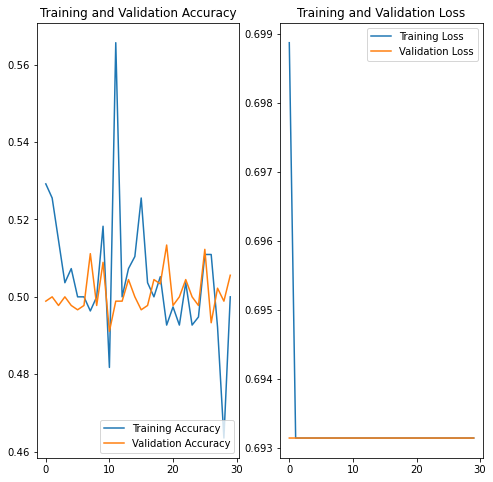

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Como puede ver en las gráficas, la precisión del entrenamiento y la precisión de la validación están separadas por un amplio margen y el modelo ha logrado solo alrededor del ** 70% ** de precisión en el conjunto de validación.

Analizaremos brevemente que salio mal y que se podría llegar a cambiar.

## Overfitting

En las gráficas anteriores, la precisión del entrenamiento aumenta linealmente con el tiempo, mientras que la precisión de la validación se detiene alrededor del 70% en el proceso de entrenamiento. Además, la diferencia en la precisión entre el entrenamiento y la precisión de la validación es notable, una señal de * overfitting *.

Cuando hay un pequeño número de ejemplos de entrenamiento, el modelo a veces aprende de los ruidos o detalles no deseados de los ejemplos de entrenamiento, hasta el punto de que impacta negativamente el desempeño del modelo en nuevos ejemplos. Este fenómeno se conoce como overfitting. Significa que el modelo tendrá dificultades para generalizar en un nuevo conjunto de datos.

Hay múltiples formas de luchar contra el sobreajuste en el proceso de entrenamiento. En este caso usaremos * aumento de datos *.

## Data augmentation

El overfitting generalmente ocurre cuando hay un pequeño número de ejemplos de entrenamiento. Una forma de solucionar este problema es aumentar el conjunto de datos para que tenga una cantidad suficiente de ejemplos de entrenamiento. El aumento de datos adopta el enfoque de generar más datos de entrenamiento a partir de muestras de entrenamiento existentes al aumentar las muestras usando transformaciones aleatorias que producen imágenes de aspecto creíble. El objetivo es que el modelo nunca verá exactamente la misma imagen dos veces durante el entrenamiento. Esto ayuda a exponer el modelo a más aspectos de los datos y a generalizar mejor.

Esto se puede implementar en `tf.keras` usando la clase `ImageDataGenerator`. Las transformaciones se aplican al conjunto de datos y durante el entrenamiento serán aplicados.

### Aumentar y visualizar datos

Comenzaremos invirtiendo horizontalmente al conjunto de datos en forma aleatoria.

### Invertir imágenes horizontalmente

Pasar `horizontal_flip` como argumento a la clase `ImageDataGenerator` y configurarlo en `True` para aplicar este aumento.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Con el siguiente comando podemos ver como de forma aleatoria se invierte la imágen.


In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(8)]

In [ ]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

### Rotación aleatoria de la imágen 

Ahora vamos a ver otro tipo de aumento diferente llamado rotación y aplicaremos 45 grados de rotación al azar a los ejemplos de entrenamiento.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(8)]

In [ ]:
plotImages(augmented_images)

### Aplicar aumento de zoom

Aplicaremos un aumento de zoom al conjunto de datos para ampliar las imágenes hasta un 50% al azar.

In [ ]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) # 

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(8)]

In [ ]:
plotImages(augmented_images)

### Aplicar todas las modificaciones

Aplicar todos los aumentos anteriores. En este caso se aplica, reescalado, rotación de 45 grados, desplazamiento de ancho, desplazamiento de altura, giro horizontal y aumento de zoom a las imágenes de entrenamiento.

In [ ]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Podemos ver cómo se vería una sola imagen ocho veces diferentes al pasar estos aumentos al azar al conjunto de datos.


In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(8)]


In [ ]:
plotImages(augmented_images)

### Crear generador de datos de validación

En general, solo se aplica el aumento de datos a los ejemplos de entrenamiento.

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [ ]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')


## Utilizar el modelo en nuevos datos


In [67]:
#test_dir = os.path.join('datasets', 'test')
#image_gen_test = ImageDataGenerator(rescale=1./255)
#test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
#                                                 directory=test_dir,
#                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                                 class_mode=None,
#                                                 shuffle=False)

img = tf.keras.preprocessing.image.load_img(
    "C:/Work/Itau/WorkShopDNN/WorkShopDNN/Notebooks/Keras/datasets/test/cats/cat.14.jpg"
)

test_data_gen.reset()
pred = model.predict(test_data_gen,
              verbose=1)                                                 
np.round(pred)

Found 5 images belonging to 1 classes.
1/1 [==============================] - 0s 3ms/step


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)